# 0.0 Imports

In [121]:
import pandas as pd
import numpy  as np

import inflection
import datetime
import random
import pickle

import seaborn as sns
#import sweetviz as sv
import scikitplot as skplt

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.core.display import HTML

from sklearn.metrics         import precision_score, recall_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn  import model_selection as ms
from sklearn  import preprocessing   as pp
from sklearn  import ensemble        as en
from sklearn  import neighbors       as nh
from sklearn  import linear_model    as lm
from xgboost  import XGBClassifier   as xgb
from lightgbm import LGBMClassifier

In [ ]:
pip install pickle

## 0.1 Helper functions

In [19]:
def rename_columns(dataframe):
    df = dataframe.copy()
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df

def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    #pd.set_option('max_columns', None, "max_rows", 50)
    pd.options.display.max_rows = 999
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def precision_recall_at_k(yhat_proba, y_val, k=2000):
    ''' receives the response probability and the validation response (or test)
    returns:
    - a tuple with precision and recall at k
    - a table with all the metrics '''
    
    table_proba = pd.DataFrame(yhat_proba)

    # add the 'response' column
    table_proba['target'] = y_val.values

    # sorting values of the correct probability column
    table_proba.sort_values(1, ascending = False, inplace = True)

    # create cumulative propensity score
    ## calculate the quantity of class 1 rows
    qty_class_1 = table_proba.groupby('target').count().loc[1,1]

    ## apply a score for every row which target is 1
    x = lambda x: 1/qty_class_1 if x['target'] == 1 else 0
    table_proba['propensity_score'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_propensity_score'] = np.cumsum(table_proba['propensity_score'])

    # create % cumulative of the base
    x = lambda x: 1/len(table_proba)
    table_proba['porc_base'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_porc_base'] = np.cumsum(table_proba['porc_base'])
    table_proba.drop('porc_base', axis = 1, inplace = True)

    # create the lift column
    table_proba['lift'] = table_proba['cumulative_propensity_score'] / table_proba['cumulative_porc_base']


    # Precision and Recall at K
    table_proba = table_proba.reset_index (drop=True)

    # create ranking order
    table_proba['ranking'] = table_proba.index + 1

    # calculate precision and recall
    table_proba['precision_at_k'] = table_proba['target'].cumsum() / table_proba['ranking']
    table_proba['recall_at_k'] = table_proba['target'].cumsum() / table_proba['target'].sum()

    precision_at_k = table_proba.loc[k-1, 'precision_at_k']

    recall_at_k = table_proba.loc[k-1, 'recall_at_k']

    return((precision_at_k, recall_at_k), table_proba)

def precision_at_k(data, k):
    data = data.reset_index(drop=True)
    data['n_samples'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['n_samples']
    return data.loc[k, 'precision_at_k']

# recall_at_k
def recall_at_k(data, k):
    data = data.reset_index(drop=True)
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    return data.loc[k, 'recall_at_k']

def cross_validation(model, model_name, x_train, y_train, k_top, kfolds, verbose=False):
    # X separate X and Y data:
    xtraining = x_train
    ytraining = y_train
    
    # cross-validation:
    cv = StratifiedKFold(n_splits=kfolds)
    prec_k_list = []
    rec_k_list = []
    i = 1
    for train_index, prim_val_index in cv.split(xtraining, ytraining):
        if verbose:
            print(f'Fold number {i}/{kfolds}')
        else:
            pass
                
        X_training, X_prim_val = xtraining.iloc[train_index], xtraining.iloc[prim_val_index]
        y_training, y_prim_val = ytraining.iloc[train_index], ytraining.iloc[prim_val_index]
        
        # remove id from training, and create new validation without id
        X_training = X_training
        X_prim_val_no_id = X_prim_val
        
        # fit and predict_proba
        model.fit(X_training, y_training)
        yhat_proba = model.predict_proba(X_prim_val_no_id)
        
        metrics, table = precision_recall_at_k(yhat_proba, y_prim_val, k_top)
        
        # transform yhat_proba to 1D-array
        ##yhat_proba_1d = yhat_proba[:, 1].tolist()
        
        # reconstruct dataframe
        ##prim_val = pd.concat([X_prim_val, y_prim_val], axis=1)
        ##prim_val['score'] = yhat_proba_1d
        ##prim_val = prim_val.sort_values('score', ascending=False)
        
        # evaluate accuracy and store in list
        ##prec_k_list.append(precision_at_k(prim_val, k_top))
        ##rec_k_list.append(recall_at_k(prim_val, k_top))
        
        prec_k_list.append(metrics[0])
        rec_k_list.append(metrics[1])
        
        i+=1
    
    #evaluate mean and std
    prec_k_pred = np.round(np.mean(prec_k_list), 4).astype(str) + '+/-' + np.round(np.std(prec_k_list), 4).astype(str)
    rec_k_pred = np.round(np.mean(rec_k_list), 4).astype(str) + '+/-' + np.round(np.std(rec_k_list), 4).astype(str)
    
    return pd.DataFrame({'Model name':model_name,
                         'precision_at_k':prec_k_pred,
                         'recall_at_k':rec_k_pred}, index=[0])


In [20]:
jupyter_settings()

## 0.2 Loading data

In [21]:
df_raw_train = pd.read_csv('../data/train.csv')
df_raw_test = pd.read_csv('../data/test.csv')

# 1.0 Data description

In [22]:
df1 = df_raw_train.copy()

## 1.1 Rename columns

In [23]:
# Using the function we created in section 0.1
df1 = rename_columns(df1)

## 1.2 Data dimensions

In [24]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of cols: 12


## 1.3 Data types

In [25]:
df1.sample(20)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
235682,235683,Female,30,1,50.0,1,< 1 Year,No,32949.0,152.0,192,0
143498,143499,Male,28,1,30.0,0,< 1 Year,Yes,2630.0,160.0,185,0
6395,6396,Female,43,1,42.0,0,1-2 Year,Yes,31077.0,26.0,116,0
61672,61673,Male,47,1,45.0,0,1-2 Year,Yes,2630.0,124.0,115,0
332341,332342,Female,31,1,23.0,1,< 1 Year,No,36136.0,152.0,35,0
207363,207364,Male,59,1,29.0,0,1-2 Year,Yes,46715.0,135.0,120,0
279697,279698,Female,31,1,36.0,0,1-2 Year,Yes,2630.0,156.0,142,0
10722,10723,Male,47,1,28.0,1,1-2 Year,No,37198.0,124.0,156,0
29094,29095,Male,24,1,36.0,0,< 1 Year,Yes,42574.0,152.0,189,0
340676,340677,Male,29,1,28.0,0,1-2 Year,Yes,2630.0,124.0,233,1


In [26]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [27]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Fillout NA 

## 1.6 Change Types

In [28]:
df1['region_code'] = df1['region_code'].astype('int64')
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

## 1.7 Descriptive Statistical

In [29]:
num_attributes = df1[['id', 'age', 'annual_premium', 'vintage']]
cat_attributes = df1[['gender', 'driving_license', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'policy_sales_channel', 'region_code', 'response']]

### 1.7.1 Numerical attributes

In [30]:
df_aux = num_attributes.describe().T[['min', 'max', 'mean', 'std']]
range_ = df_aux['min'] - df_aux['max']
kurt = num_attributes.kurt(axis=0)
skew = num_attributes.skew(axis=0)

df_aux['range'] = range_
df_aux['kurt'] = kurt
df_aux['skew'] = skew

df_aux

,min,max,mean,std,range,kurt,skew
id,1.0,381109.0,190555.000000,110016.836208,-381108.0,-1.200000,9.443274e-16
age,20.0,85.0,38.822584,15.511611,-65.0,-0.565655,6.725390e-01
annual_premium,2630.0,540165.0,30564.389581,17213.155057,-537535.0,34.004569,1.766087e+00
vintage,10.0,299.0,154.347397,83.671304,-289.0,-1.200688,3.029517e-03


### 1.7.2 Categorical attributes

In [31]:
cat_attributes

,gender,driving_license,previously_insured,vehicle_age,vehicle_damage,policy_sales_channel,region_code,response
0,Male,1,0,> 2 Years,Yes,26,28,1
1,Male,1,0,1-2 Year,No,26,3,0
2,Male,1,0,> 2 Years,Yes,26,28,1
3,Male,1,1,< 1 Year,No,152,11,0
4,Female,1,1,< 1 Year,No,152,41,0
...,...,...,...,...,...,...,...,...
381104,Male,1,1,1-2 Year,No,26,26,0
381105,Male,1,1,< 1 Year,No,152,37,0
381106,Male,1,1,< 1 Year,No,160,30,0
381107,Female,1,0,> 2 Years,Yes,124,14,0


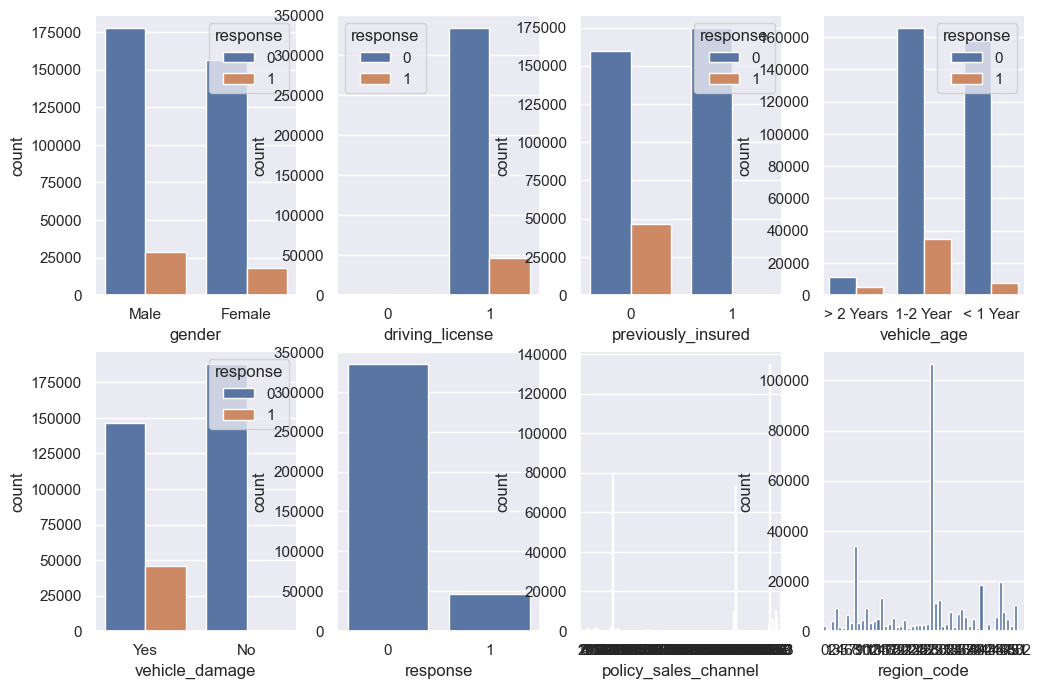

In [32]:
aux = df1.copy()

plt.subplot(2, 4, 1)
sns.countplot(x='gender', hue='response', data=aux);

plt.subplot(2, 4, 2)
sns.countplot(x='driving_license', hue='response', data=aux);

plt.subplot(2, 4, 3)
sns.countplot(x='previously_insured', hue='response', data=aux);

plt.subplot(2, 4, 4)
sns.countplot(x='vehicle_age', hue='response', data=aux);

plt.subplot(2, 4, 5)
sns.countplot(x='vehicle_damage', hue='response', data=aux);

plt.subplot(2, 4, 6)
sns.countplot(x='response', data=aux);

plt.subplot(2, 4, 7)
sns.countplot(x='policy_sales_channel', data=aux);

plt.subplot(2, 4, 8)
sns.countplot(x='region_code', data=aux);

# 2.0 Feature engineering

In [33]:
df2 = df1.copy()

## 2.1 Mapa mental de Hipoteses

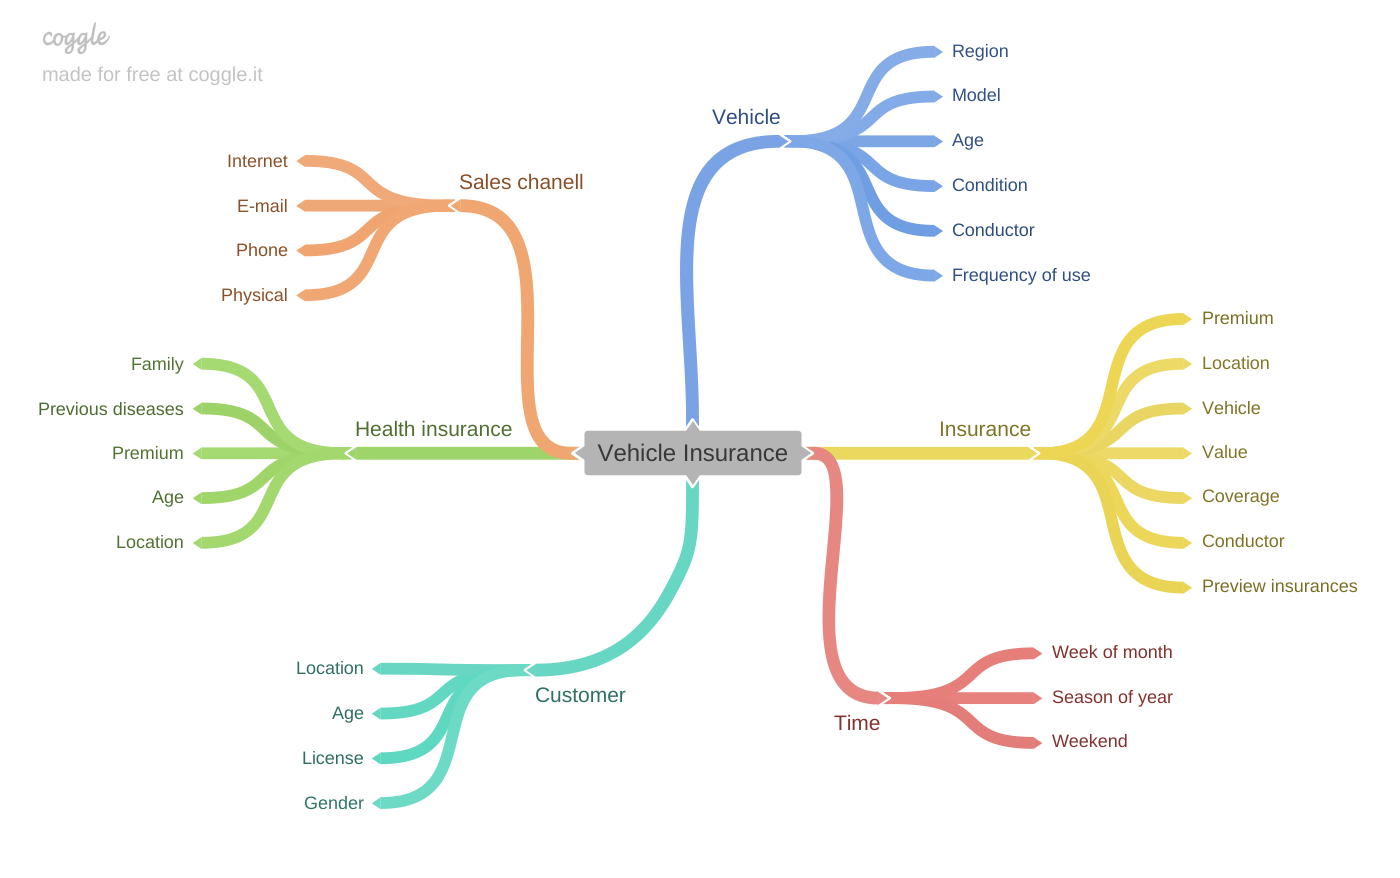

## 2.2 Criação de Hipoteses

- Vehicles
    - Vehicle with higher are have more probability to adquire insurance
    - Vehicles that got damaged have more probability to adquire insurance
    - Vehicles that already had an insurance have more probability to adquire insurance
    
    
- Health Insurance
    - Higher premium have more probability to adquire insurance
    - More days associeted have more probability to adquire insurance
    
- Customer
    - Higher age have more probability to adquire insurance
    - Female gender have more probability to adquire insurance
    - Dangerous location have more probability to adquire insurance
    
- Time - no data available
- Insurance - no data available
- Sales channel - no data available
    

## 2.3 Splitting dataset

In [34]:
X = df2.drop('response', axis=1).copy()
y = df2['response'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 42)

df2 = pd.concat([X_train, y_train], axis=1)

df_test = pd.concat([X_test, y_test], axis=1)

## 2.4 Feature engineering

In [35]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
274710,274711,Male,22,1,40,0,< 1 Year,Yes,25455.0,152,203,0
216539,216540,Female,26,1,8,1,< 1 Year,No,38393.0,26,45,0
78983,78984,Female,32,1,28,0,< 1 Year,Yes,32118.0,122,35,1
218368,218369,Male,32,1,37,0,< 1 Year,Yes,37711.0,152,215,0
307215,307216,Female,24,1,28,0,< 1 Year,Yes,48706.0,156,222,0


In [36]:
df2['vehicle_damage'].unique()

array(['Yes', 'No'], dtype=object)

In [37]:
damage = {'Yes': 1, 'No':0}

df2['vehicle_damage'] = df2['vehicle_damage'].map(damage)

# 3.0 Feature filtering

In [38]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

## 3.2 Seleção das colunas

# 4.0 EDA - Análise exploratória dos dados

In [39]:
df4 = df3.copy()

In [40]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
274710,274711,Male,22,1,40,0,< 1 Year,1,25455.0,152,203,0
216539,216540,Female,26,1,8,1,< 1 Year,0,38393.0,26,45,0
78983,78984,Female,32,1,28,0,< 1 Year,1,32118.0,122,35,1
218368,218369,Male,32,1,37,0,< 1 Year,1,37711.0,152,215,0
307215,307216,Female,24,1,28,0,< 1 Year,1,48706.0,156,222,0


## 4.1 Análise univariada

### 4.1.1 Response variable

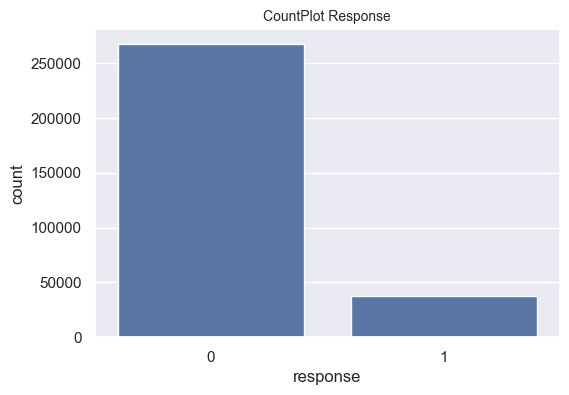

In [41]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=df2, x='response', ax=ax)
ax.set_title("CountPlot Response", fontsize=10);

In [42]:
response_count = {
    'count':[len(df4[df4['response']==0]), len(df4[df4['response']==1])],
}
df_response = pd.DataFrame.from_dict(response_count)
df_response['percent'] = df_response['count'] / len(df4)
df_response

,count,percent
0,267519,0.877437
1,37368,0.122563


### 4.1.2 Numerical variable

C:\Users\gabri\AppData\Local\Temp\ipykernel_4276\2533347166.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df4.hist(ax=ax, bins= 10);


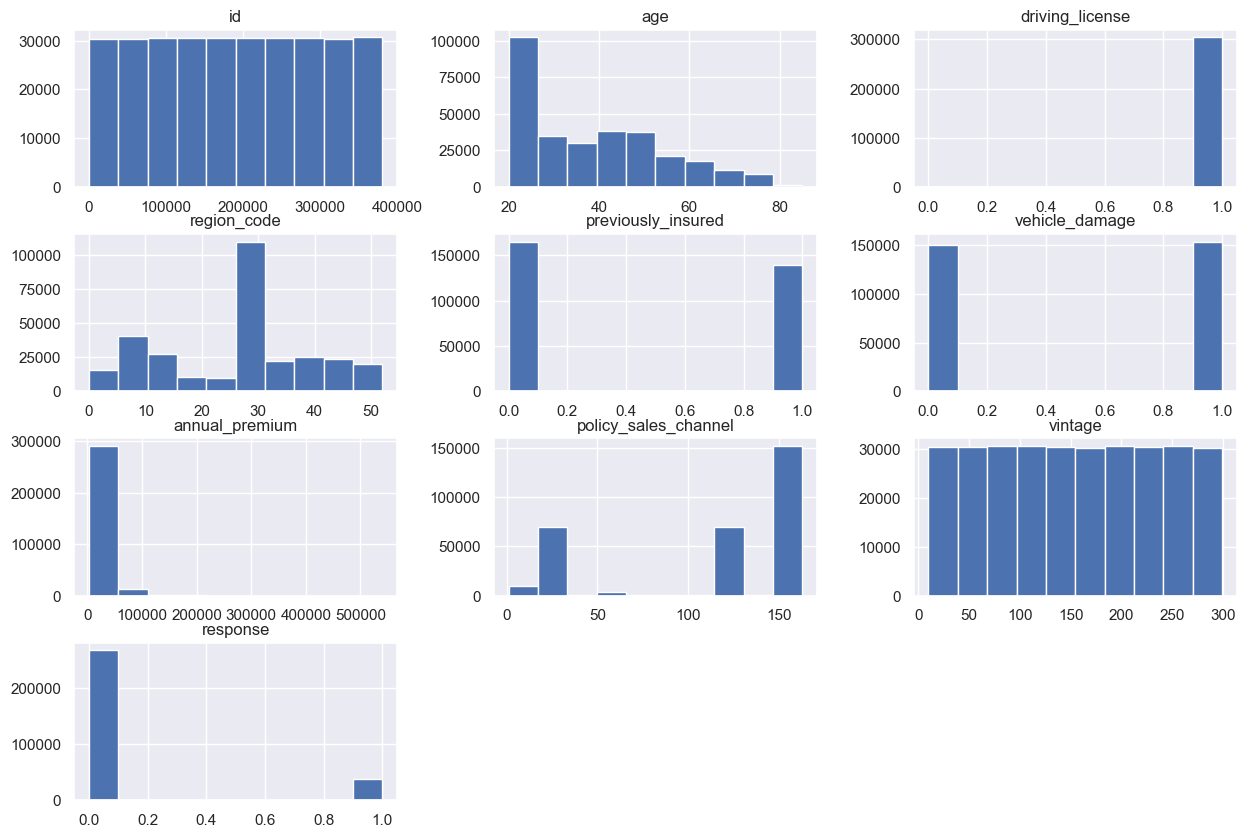

In [43]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df4.hist(ax=ax, bins= 10);

### 4.1.3 Categorical variable

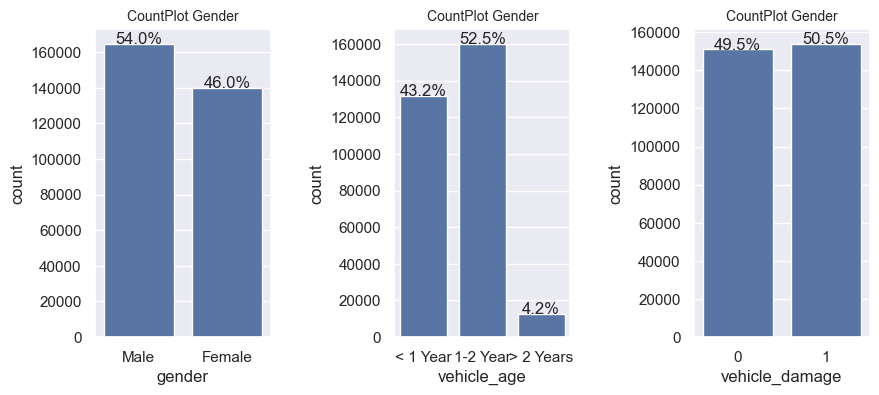

In [44]:
# gender
fig, ax = plt.subplots(1,3, figsize=(10,4))

sns.countplot(data=df4, x='gender', ax=ax[0])
ax[0].set_title("CountPlot Gender", fontsize=10);
for p in ax[0].patches:
            height = p.get_height()
            ax[0].text(p.get_x() + p.get_width()/2., height + 3, '{:.1f}%'.format(height/len(df4)*100), ha="center")
            
# vehicle_age
sns.countplot(data=df4, x='vehicle_age', ax=ax[1])
ax[1].set_title("CountPlot Gender", fontsize=10);
for p in ax[1].patches:
            height = p.get_height()
            ax[1].text(p.get_x() + p.get_width()/2., height + 3, '{:.1f}%'.format(height/len(df4)*100), ha="center")

# vehicle_damage
sns.countplot(data=df4, x='vehicle_damage', ax=ax[2])
ax[2].set_title("CountPlot Gender", fontsize=10);
for p in ax[2].patches:
            height = p.get_height()
            ax[2].text(p.get_x() + p.get_width()/2., height + 3, '{:.1f}%'.format(height/len(df4)*100), ha="center")
            
plt.subplots_adjust(wspace=0.7)

## 4.2 Análise bivariada

* Vehicles 
    - Vehicle with higher age have more probability to adquire insurance

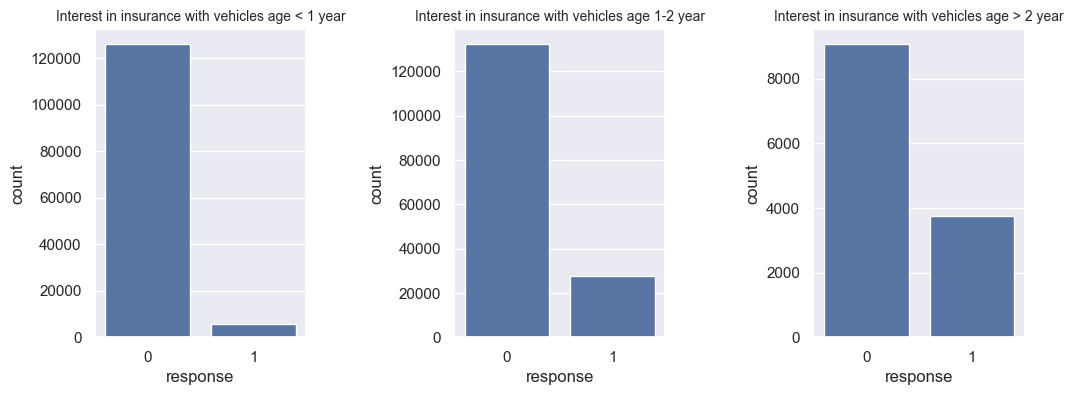

In [45]:
#Vehicles
fig, ax = plt.subplots(1,3,figsize=(12,4))

aux = df4[df4['vehicle_age']=='< 1 Year']
sns.countplot(data=aux, x='response', ax=ax[0])
ax[0].set_title("Interest in insurance with vehicles age < 1 year", fontsize=10);

aux = df4[df4['vehicle_age']=='1-2 Year']
sns.countplot(data=aux, x='response', ax=ax[1])
ax[1].set_title("Interest in insurance with vehicles age 1-2 year", fontsize=10);

aux = df4[df4['vehicle_age']=='> 2 Years']
sns.countplot(data=aux, x='response', ax=ax[2])
ax[2].set_title("Interest in insurance with vehicles age > 2 year", fontsize=10);

plt.subplots_adjust(wspace=0.7)

Hypothesis is true, clients with older vehicles has more intereset in adquiring insurance

- Vehicles that got damaged have more probability to adquire insurance

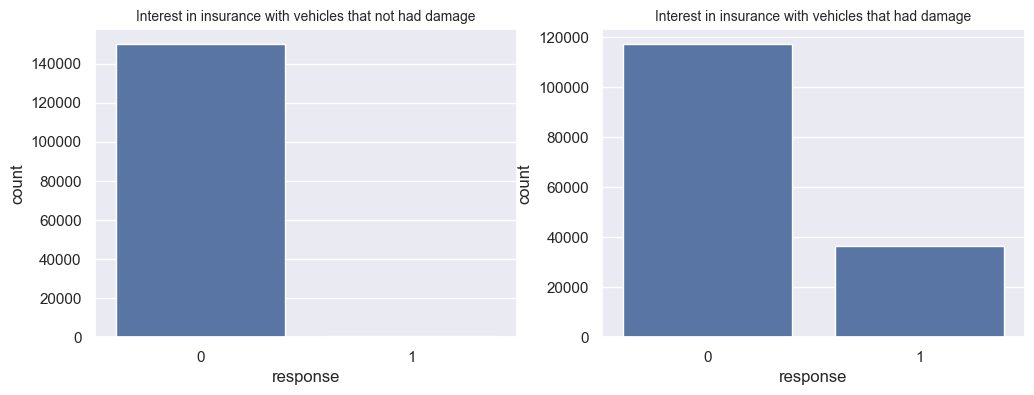

In [46]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

aux = df4[df4['vehicle_damage']==0]
sns.countplot(data=aux, x='response', ax=ax[0])
ax[0].set_title("Interest in insurance with vehicles that not had damage", fontsize=10);

aux = df4[df4['vehicle_damage']==1]
sns.countplot(data=aux, x='response', ax=ax[1])
ax[1].set_title("Interest in insurance with vehicles that had damage", fontsize=10);

Hypothesis is true, clients with vehicles that had damage have more interest in adquire insurance

- Vehicles that already had an insurance have more probability to adquire insurance

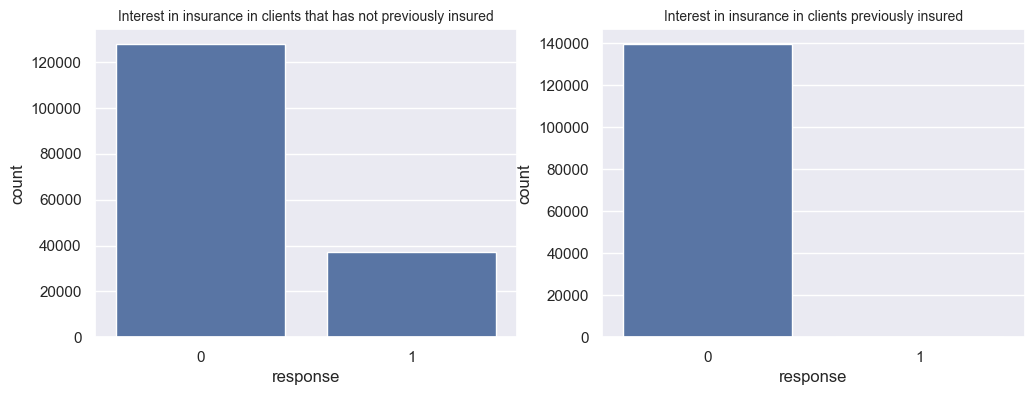

In [47]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

aux = df4[df4['previously_insured']==0]
sns.countplot(data=aux, x='response', ax=ax[0])
ax[0].set_title("Interest in insurance in clients that has not previously insured", fontsize=10);

aux = df4[df4['previously_insured']==1]
sns.countplot(data=aux, x='response', ax=ax[1])
ax[1].set_title("Interest in insurance in clients previously insured", fontsize=10);

Hypothesis is false, clients previously insured have less intereset in adquiring insurance

- Health Insurance
    - Higher premium have more probability to adquire insurance

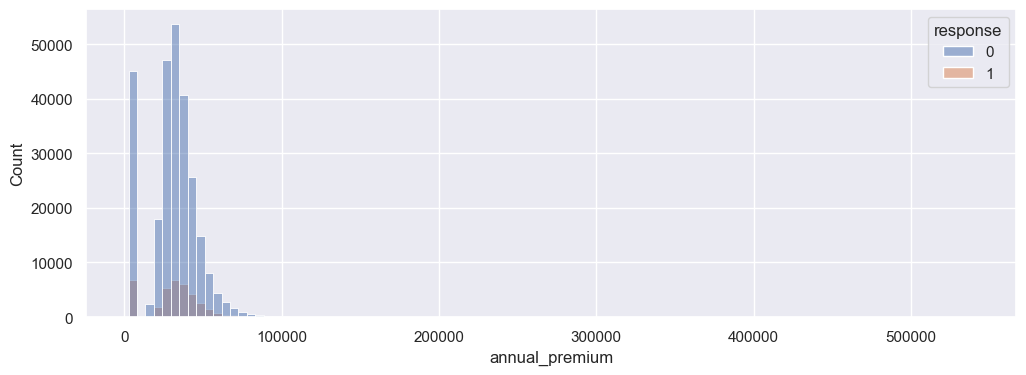

In [48]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(x='annual_premium', hue='response', data=df4, bins=100, ax=ax);

Hypothesis is false, clients with higher annual premium have less interest in insurance

- More days associeted have more probability to adquire insurance


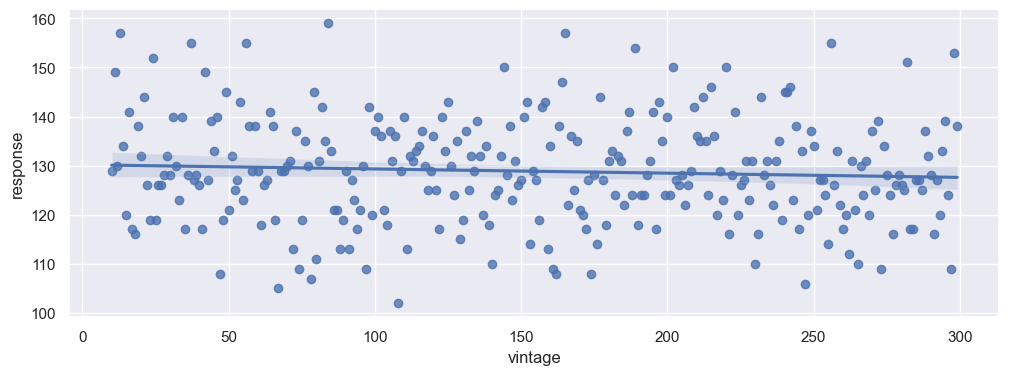

In [49]:
fig, ax = plt.subplots(figsize=(12,4))
aux = df4[['vintage', 'response']].groupby('vintage').sum().reset_index()
sns.regplot(x='vintage', y='response', data=aux, ax=ax);

Hypotehsis is false, clients with more days associeted have less intereset in insurance

- Customer
    - Higher age have more probability to adquire insurance

<Axes: xlabel='response', ylabel='age'>

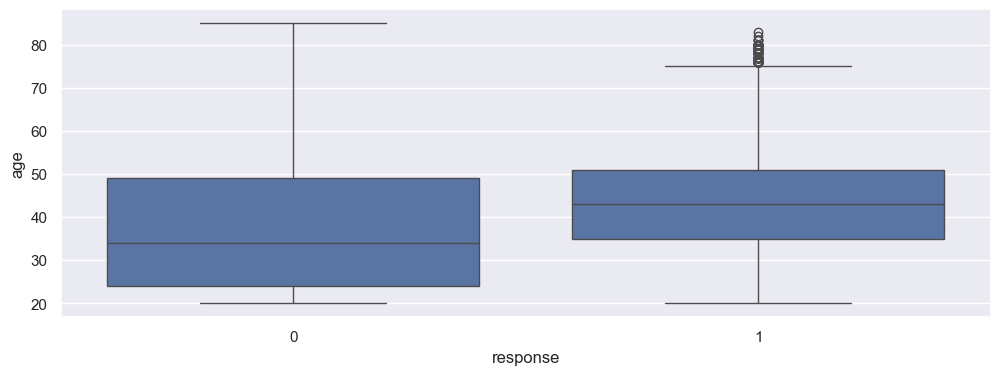

In [50]:
fig, ax = plt.subplots(figsize=(12,4))
sns.boxplot(x='response', y='age', data=df4, ax=ax)

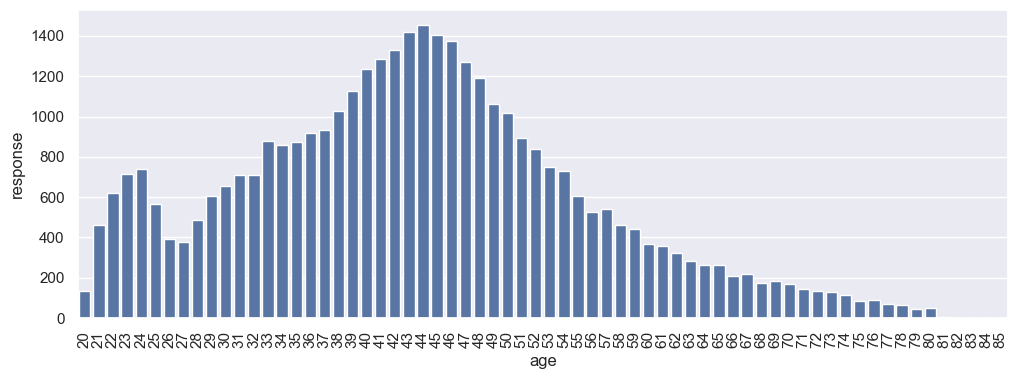

In [51]:
fig, ax = plt.subplots(figsize=(12,4))
aux = df4[['age', 'response']].groupby('age').sum().reset_index()
sns.barplot(x='age', y='response', data=aux, ax=ax)
plt.xticks( rotation=90 );

Hypothesis is false, customers with higher age have less interest in insurance

- Female gender have more probability to adquire insurance

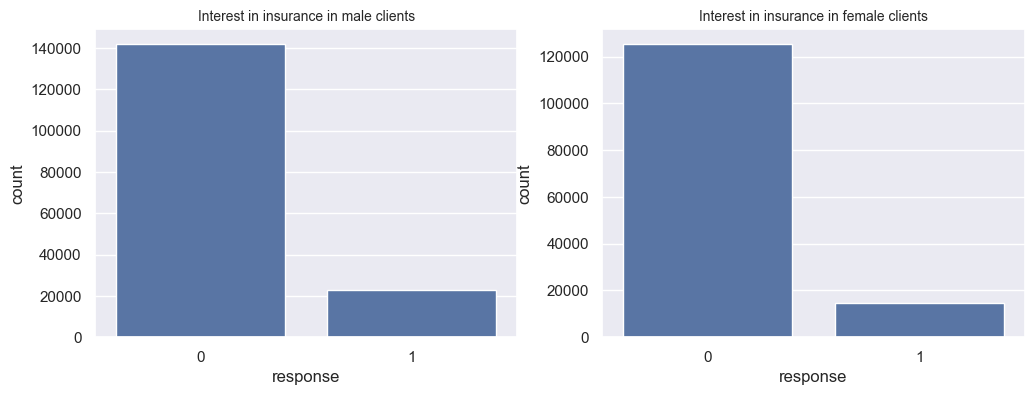

In [52]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

aux = df4[df4['gender']=='Male']
sns.countplot(data=aux, x='response', ax=ax[0])
ax[0].set_title("Interest in insurance in male clients", fontsize=10);

aux = df4[df4['gender']=='Female']
sns.countplot(data=aux, x='response', ax=ax[1])
ax[1].set_title("Interest in insurance in female clients", fontsize=10);

In [53]:
df4

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
274710,274711,Male,22,1,40,0,< 1 Year,1,25455.0,152,203,0
216539,216540,Female,26,1,8,1,< 1 Year,0,38393.0,26,45,0
78983,78984,Female,32,1,28,0,< 1 Year,1,32118.0,122,35,1
218368,218369,Male,32,1,37,0,< 1 Year,1,37711.0,152,215,0
307215,307216,Female,24,1,28,0,< 1 Year,1,48706.0,156,222,0
...,...,...,...,...,...,...,...,...,...,...,...,...
378816,378817,Male,25,1,47,1,< 1 Year,1,23010.0,160,58,0
67726,67727,Male,69,1,28,0,1-2 Year,1,31630.0,26,290,1
91744,91745,Male,24,1,28,0,< 1 Year,0,59094.0,152,62,0
48700,48701,Female,40,1,8,1,1-2 Year,0,28940.0,26,262,0


### 4.2.x Hipothesis validation

### 4.2.y Hipothesis resume

## 4.3 Análise multivariada

### 4.3.1 Numerical attributes

### 4.3.2 Categorical attributes

# 5.0 Data Preparation

In [54]:
df5 = df4.copy()

## 5.1 Normalization

In [55]:
# annual_premium -> StandardScaler
ss = pp.StandardScaler()
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

In [56]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
274710,274711,Male,22,1,40,0,< 1 Year,1,-0.297943,152,203,0
216539,216540,Female,26,1,8,1,< 1 Year,0,0.452554,26,45,0
78983,78984,Female,32,1,28,0,< 1 Year,1,0.088559,122,35,1
218368,218369,Male,32,1,37,0,< 1 Year,1,0.412993,152,215,0
307215,307216,Female,24,1,28,0,< 1 Year,1,1.050781,156,222,0


## 5.2 Rescaling

In [57]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## 5.3 Encoding

In [58]:
# gender
gender_target = df5[['gender', 'response']].groupby('gender')['response'].mean()
df5['gender'] = df5['gender'].map(gender_target)

# region code
region_encoder = df5[['region_code', 'response']].groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map(region_encoder)

# vehicle_age
age_dict = {'< 1 Year':'below_1_year', '1-2 Year':'between_1_2_year', '> 2 Years':'above_2_year'}
df5['vehicle_age'] = df5['vehicle_age'].map(age_dict)

df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_chanel
policy_encoder = df5.groupby('policy_sales_channel').size() / len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(policy_encoder)

## 5.4 Test preparation

In [59]:
df_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
16221,16222,Male,54,1,28,0,> 2 Years,Yes,75219.0,26,53,1
342480,342481,Female,26,1,3,0,1-2 Year,Yes,19738.0,156,280,0
20915,20916,Male,25,1,28,0,< 1 Year,Yes,61524.0,124,255,0
38703,38704,Male,29,1,24,0,1-2 Year,Yes,2630.0,157,235,1
363808,363809,Female,28,1,28,0,< 1 Year,Yes,51473.0,26,243,1
...,...,...,...,...,...,...,...,...,...,...,...,...
151614,151615,Male,40,1,28,0,1-2 Year,Yes,32747.0,124,140,0
170170,170171,Female,39,1,48,0,1-2 Year,No,2630.0,124,178,0
303221,303222,Male,60,1,28,0,1-2 Year,Yes,36965.0,26,285,0
333829,333830,Male,23,1,15,1,< 1 Year,No,28270.0,152,98,0


In [60]:
df_test['vehicle_damage'] = df_test['vehicle_damage'].map(damage)

# annual_premiu -> StandardScaler
df_test['annual_premium'] = ss.fit_transform(df_test[['annual_premium']].values)

# age
df_test['age'] = mms_age.fit_transform(df_test[['age']].values)

# vintage
df_test['vintage'] = mms_vintage.fit_transform(df_test[['vintage']].values)

# gender
df_test['gender'] = df_test['gender'].map(gender_target)

# region code
df_test['region_code'] = df_test['region_code'].map(region_encoder)

# vehicle_age
df_test['vehicle_age'] = df_test['vehicle_age'].map(age_dict)

df_test = pd.get_dummies(df_test, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_chanel
df_test['policy_sales_channel'] = df_test['policy_sales_channel'].map(policy_encoder)

In [61]:
df_test.isna().sum()

id                              0
gender                          0
age                             0
driving_license                 0
region_code                     0
previously_insured              0
vehicle_damage                  0
annual_premium                  0
policy_sales_channel            1
vintage                         0
response                        0
vehicle_age_above_2_year        0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
dtype: int64

In [62]:
df_test.loc[df_test['policy_sales_channel'].isna()]

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_above_2_year,vehicle_age_below_1_year,vehicle_age_between_1_2_year
279714,279715,0.138069,0.723077,1,0.187042,1,0,0.162457,NaN,0.968858,0,False,False,True


In [63]:
df_test = df_test.drop(index = [279714])

In [64]:
y_test = df_test['response']
X_test = df_test.drop('response', axis=1)

# 6.0 Feature selection

In [65]:
df6 = df5.copy()

## 6.1 Splitting dataframe for validation

In [66]:
X = df6.drop(['response', 'id'], axis = 1).copy() # 304887 rows × 12 columns
y = df6['response'].copy() #Length: 304887

#Split Train into Val:
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, stratify = y, test_size=0.10, random_state = 45)

## 6.2 Extra Trees as Feature Selector

In [67]:
extra_trees = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

In [68]:
# data preparation
x_train_n = X_train 
y_train_n = y_train.values
extra_trees.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                        feature  importance
0                       vintage    0.271046
0                annual_premium    0.242200
0                           age    0.169291
0                   region_code    0.104967
0                vehicle_damage    0.067514
0          policy_sales_channel    0.061199
0            previously_insured    0.056447
0      vehicle_age_below_1_year    0.013654
0  vehicle_age_between_1_2_year    0.005955
0                        gender    0.004747
0      vehicle_age_above_2_year    0.002441
0               driving_license    0.000539


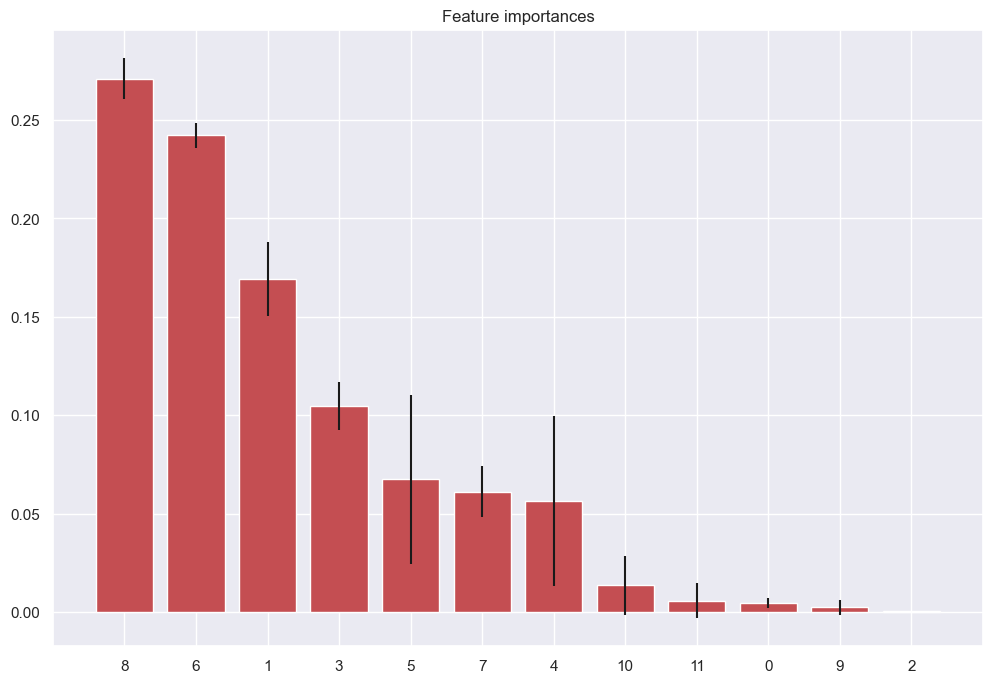

In [69]:
importances = extra_trees.feature_importances_
std = np.std( [tree.feature_importances_ for tree in extra_trees.estimators_], axis=0 )
indices = np.argsort(importances)[::-1] #trees importance ordered by greater value

# Print feature ranking
print('Feature Ranking:')
df_imp = pd.DataFrame()
for i, j in zip( x_train_n, extra_trees.feature_importances_ ):
    aux = pd.DataFrame( {'feature':i , 'importance': j}, index=[0] )
    df_imp = pd.concat( [df_imp, aux], axis=0 )
    
print(df_imp.sort_values('importance', ascending=False) )

# Plot the imputity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_n.shape[1]), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()

## 6.3 Manual feature selection

Let's select the 7 best features by the ExtraTreesClassifier and then we will check the performance with them

In [70]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 
                 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

In [71]:
# New data with selected columns by the ExtraTrees
X_train = X_train[cols_selected]
X_val = X_val[cols_selected]

# 7.0 Machine Learning Modelling - First steps

In the first steps of machine learning modelling we will evaluate three models comparing their performance, 
then with the best model we will run a more detailed analysis through cross validation and hyperparameter tuning.

## 7.1 KNN

In [72]:
# Model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=8)

# Model training
knn_model.fit(X_train, y_train.values.ravel())

# Model prediction (proba)
yhat_proba_knn = knn_model.predict_proba( X_val );

# Model prediction
yhat_predict_knn = knn_model.predict(X_val);

## 7.2 Logistic Regression

In [73]:
# Model definition
lr_model = lm.LogisticRegression(class_weight='balanced', random_state=42)

# Model training
lr_model.fit(X_train, y_train.values.ravel())

# Model prediction (proba)
yhat_proba_lr = lr_model.predict_proba(X_val)

# Model prediction
yhat_predict_lr = lr_model.predict(X_val)

## 7.3 LGBM

In [74]:
# Model definition
lgbm_model = LGBMClassifier(random_state=42, verbose = -1)

# Model training
lgbm_model.fit(X_train, y_train.values.ravel())

# Model prediction (proba)
yhat_proba_lgbm = lgbm_model.predict_proba(X_val);

# Model prediction
yhat_predict_lgbm = lgbm_model.predict(X_val);

## 7.4 ExtraTrees

In [75]:
# Model definition
et_model = en.ExtraTreesClassifier(n_estimators=100, random_state=30, n_jobs=-1)

# Model training
et_model.fit(X_train, y_train.values.ravel())

# Model prediction (proba)
yhat_proba_et = et_model.predict_proba( X_val );

# Model prediction
yhat_predict_et = et_model.predict(X_val);

## 7.5 XGBoost Classifier

In [76]:
# Model definition
xgb_model = xgb(n_estimators=100, random_state=30, n_jobs=-1)

# Model training
xgb_model.fit(X_train, y_train.values.ravel())

# Model prediction (proba)
yhat_proba_xgb = xgb_model.predict_proba( X_val );

# Model prediction
yhat_predict_xgb = xgb_model.predict(X_val);

## 7.6 Models Evaluation


In [77]:
# Define the value of the k using 40% of the base
k = int(X_val.shape[0]*0.4)

### 7.6.1 KNN

#### Accuracy, Precision and Recall

In [78]:
accuracy_knn = accuracy_score(y_val, yhat_predict_knn)

precision_knn = precision_score(y_val, yhat_predict_knn)

recall_knn = recall_score(y_val, yhat_predict_knn)

#### Cumulative Gain and Lift Curve

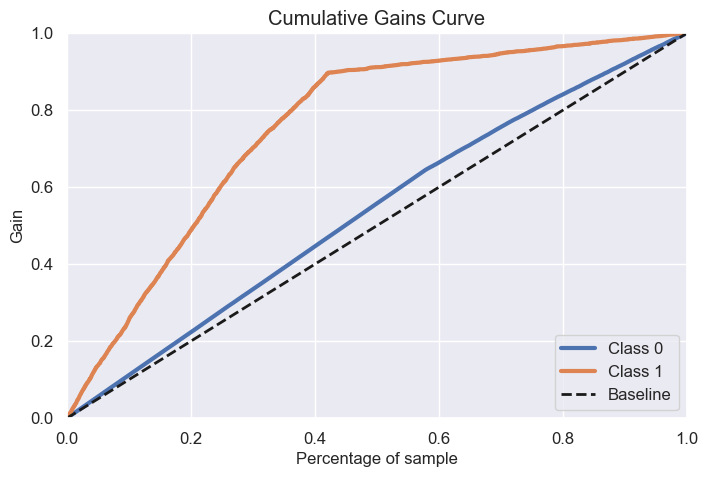

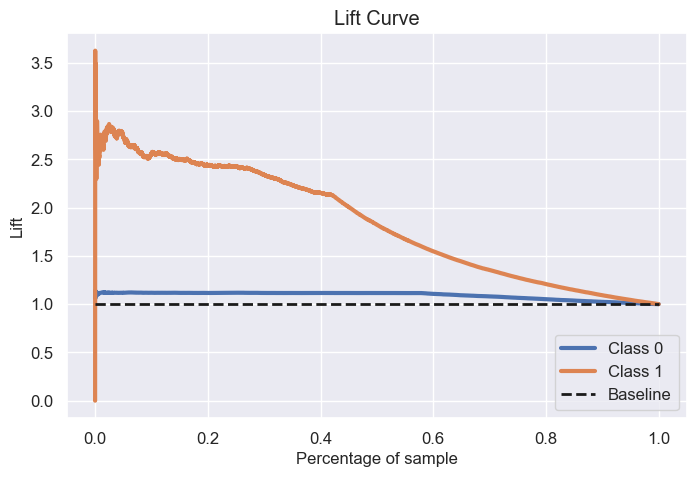

In [79]:
# Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_knn, figsize = (8,5));

# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_proba_knn, figsize = (8,5));

#### Precision@k and Recall@k

In [80]:
metrics_knn, table_knn = precision_recall_at_k(yhat_proba_knn, y_val, 2000)

In [81]:
print(f'Precision at K: {metrics_knn[0]}')
print(f'Recall at K: {metrics_knn[1]}')

Precision at K: 0.3225
Recall at K: 0.1725983409151726


#### Results

In [82]:
knn_results = pd.DataFrame({
    'Model Name':'KNN Classifier',
    'Accuracy':accuracy_knn, 
    'Precision':precision_knn, 
    'Recall':recall_knn, 
    'Precision@K':metrics_knn[0], 
    'Recall@K':metrics_knn[1]
}, index=[0])

### 7.6.2 Logistic Regression

#### Accuracy, Precision and Recall

In [83]:
accuracy_lr = accuracy_score(y_val, yhat_predict_lr)

precision_lr = precision_score(y_val, yhat_predict_lr)

recall_lr = recall_score(y_val, yhat_predict_lr)

#### Cumulative Gain and Lift Curve

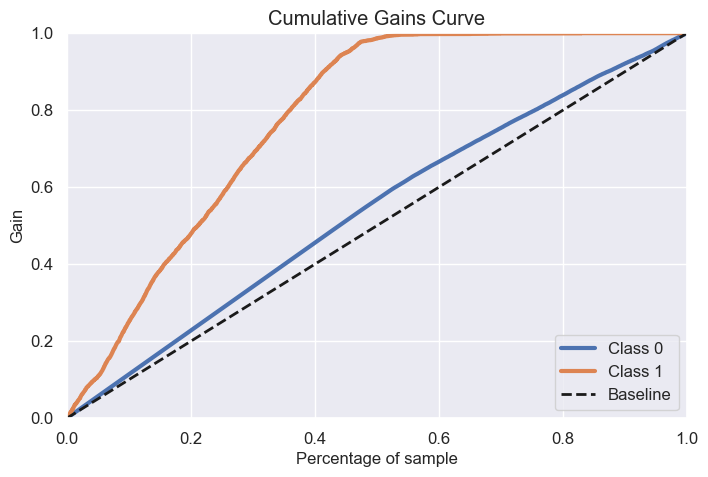

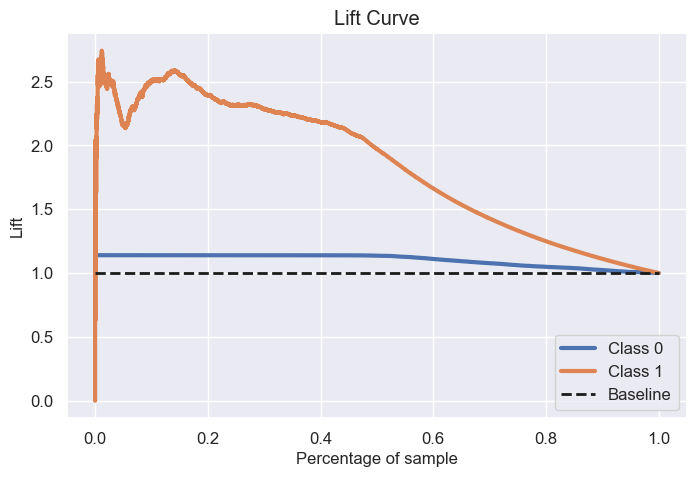

In [84]:
# Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_lr, figsize = (8,5));

# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_proba_lr, figsize = (8,5));

#### Precision@k and Recall@k

In [85]:
metrics_lr, table_lr = precision_recall_at_k(yhat_proba_lr, y_val, k)

In [86]:
print(f'Precision at K: {metrics_lr[0]}')
print(f'Recall at K: {metrics_lr[1]}')

Precision at K: 0.26756867568675685
Recall at K: 0.8731602890018731


#### Results

In [87]:
lr_results = pd.DataFrame({
    'Model Name':'Logistic Regression Classifier',
    'Accuracy':accuracy_lr, 
    'Precision':precision_lr, 
    'Recall':recall_lr, 
    'Precision@K':metrics_lr[0], 
    'Recall@K':metrics_lr[1]
}, index=[0])

### 7.6.3 LGBMClassifier

#### Accuracy, Precision and Recall

In [88]:
accuracy_lgbm = accuracy_score(y_val, yhat_predict_lgbm)

precision_lgbm = precision_score(y_val, yhat_predict_lgbm)

recall_lgbm = recall_score(y_val, yhat_predict_lgbm)

#### Cumulative Gain and Lift Curve

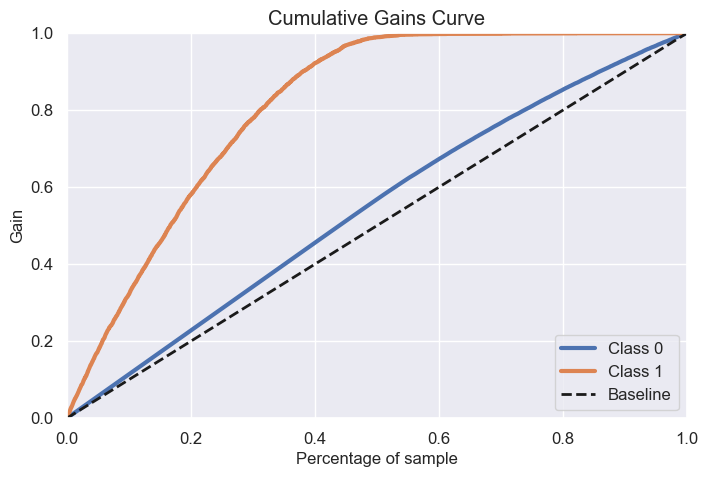

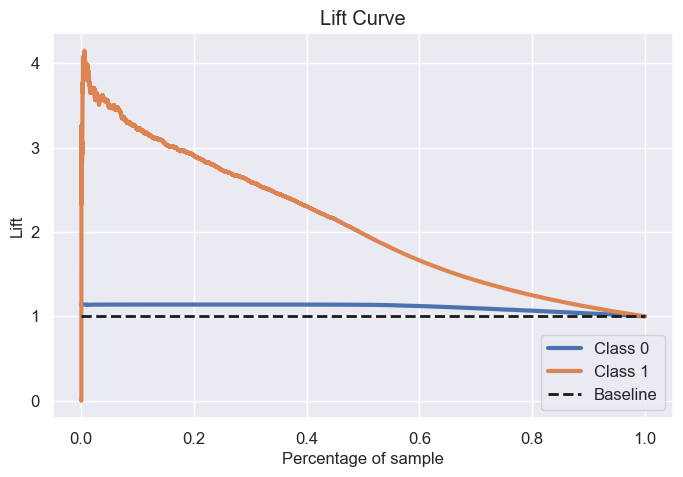

In [89]:
# Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_lgbm, figsize = (8,5));

# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_proba_lgbm, figsize = (8,5));

#### Precision@k and Recall@k

In [90]:
metrics_lgbm, table_lgbm = precision_recall_at_k(yhat_proba_lgbm, y_val, k)

In [91]:
print(f'Precision at K: {metrics_lgbm[0]}')
print(f'Recall at K: {metrics_lgbm[1]}')

Precision at K: 0.2825748257482575
Recall at K: 0.9221300508429221


#### Results

In [92]:
lgbm_results = pd.DataFrame({
    'Model Name':'LBGM Classifier',
    'Accuracy':accuracy_lgbm, 
    'Precision':precision_lgbm, 
    'Recall':recall_lgbm, 
    'Precision@K':metrics_lgbm[0], 
    'Recall@K':metrics_lgbm[1]
}, index=[0])

### 7.6.4 ExtraTrees

#### Accuracy, Precision and Recall

In [93]:
accuracy_et = accuracy_score(y_val, yhat_predict_et)

precision_et = precision_score(y_val, yhat_predict_et)

recall_et = recall_score(y_val, yhat_predict_et)

#### Cumulative Gain and Lift Curve

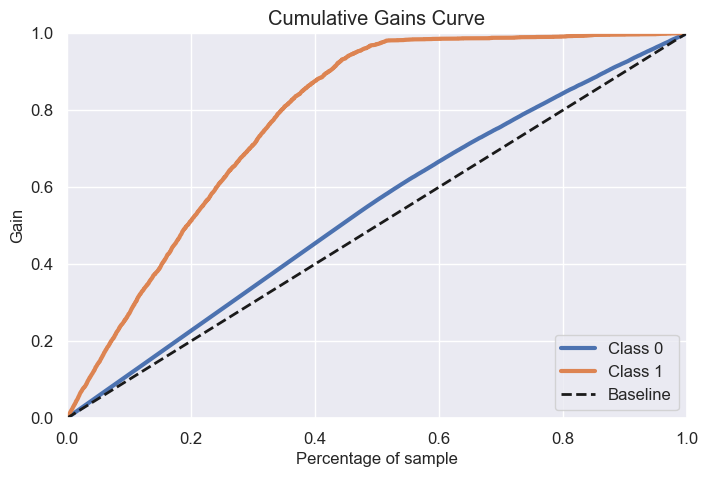

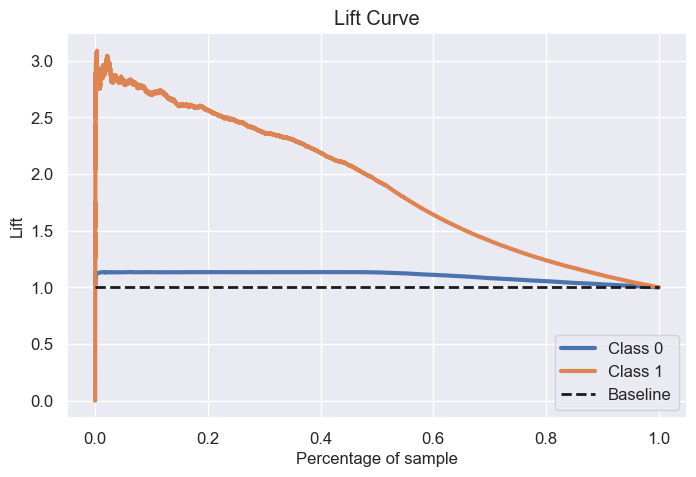

In [94]:
# Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_et, figsize = (8,5));

# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_proba_et, figsize = (8,5));

#### Precision@k and Recall@k

In [95]:
metrics_et, table_et = precision_recall_at_k(yhat_proba_et, y_val, k)

In [96]:
print(f'Precision at K: {metrics_et[0]}')
print(f'Recall at K: {metrics_et[1]}')

Precision at K: 0.26838868388683884
Recall at K: 0.8758362322718758


#### Results

In [97]:
et_results = pd.DataFrame({
    'Model Name':'ExtraTrees Classifier',
    'Accuracy':accuracy_et, 
    'Precision':precision_et, 
    'Recall':recall_et, 
    'Precision@K':metrics_et[0], 
    'Recall@K':metrics_et[1]
}, index=[0])

### 7.6.5 XGBoostClassifier

#### Accuracy, Precision and Recall

In [98]:
accuracy_xgb = accuracy_score(y_val, yhat_predict_xgb)

precision_xgb = precision_score(y_val, yhat_predict_xgb)

recall_xgb = recall_score(y_val, yhat_predict_xgb)

#### Cumulative Gain and Lift Curve

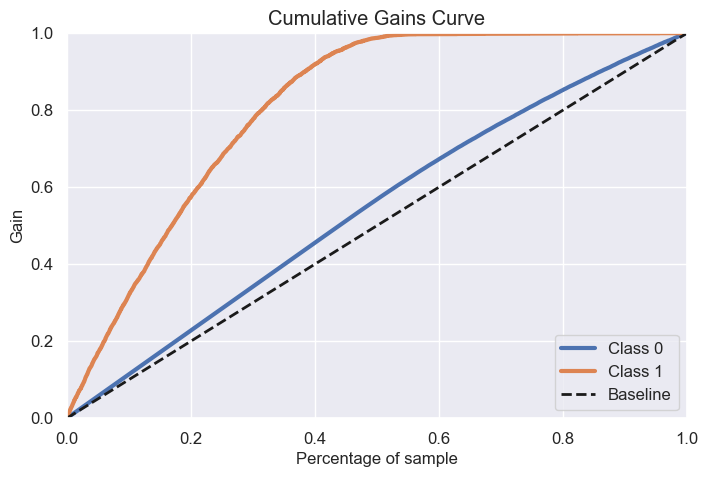

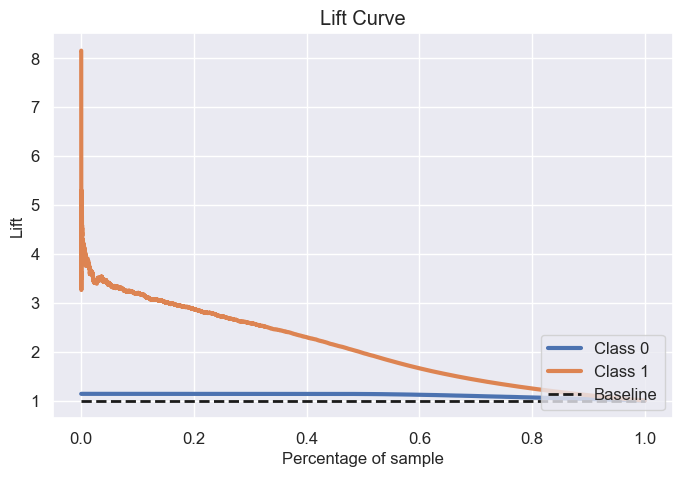

In [99]:
# Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_xgb, figsize = (8,5));

# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_proba_xgb, figsize = (8,5));

#### Precision@k and Recall@k

In [100]:
metrics_xgb, table_xgb = precision_recall_at_k(yhat_proba_xgb, y_val, k)

In [101]:
print(f'Precision at K: {metrics_xgb[0]}')
print(f'Recall at K: {metrics_xgb[1]}')

Precision at K: 0.2815088150881509
Recall at K: 0.9186513245919187


#### Results

In [102]:
xgb_results = pd.DataFrame({
    'Model Name':'XGBoost Classifier',
    'Accuracy':accuracy_xgb, 
    'Precision':precision_xgb, 
    'Recall':recall_xgb, 
    'Precision@K':metrics_xgb[0], 
    'Recall@K':metrics_xgb[1]
}, index=[0])

### 7.6.6 Results

#### Performance

In [103]:
results = pd.concat([knn_results, lr_results, lgbm_results, et_results, xgb_results])

results.sort_values(by = 'Recall@K', ascending = False)

,Model Name,Accuracy,Precision,Recall,Precision@K,Recall@K
0,LBGM Classifier,0.877234,0.384615,0.002676,0.282575,0.922130
0,XGBoost Classifier,0.877464,0.503597,0.018732,0.281509,0.918651
0,ExtraTrees Classifier,0.860802,0.343228,0.148515,0.268389,0.875836
0,Logistic Regression Classifier,0.641674,0.252104,0.978057,0.267569,0.873160
0,KNN Classifier,0.869756,0.348837,0.072250,0.322500,0.172598


#### Cumulative gain curves

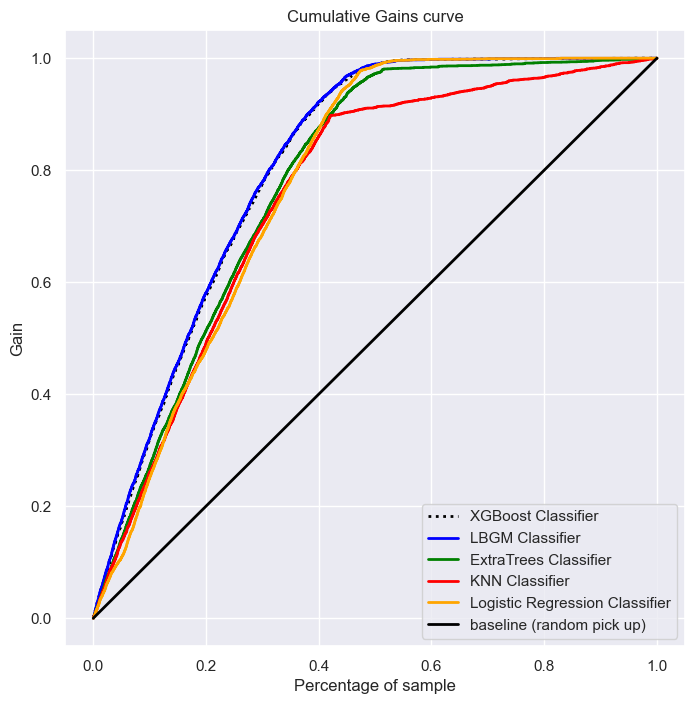

In [104]:
# plot the graphics
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.lineplot(ax = axes, x = table_xgb['cumulative_porc_base'], y = table_xgb['cumulative_propensity_score'], label="XGBoost Classifier", linewidth = 2, color = 'black')
sns.lineplot(ax = axes, x = table_lgbm['cumulative_porc_base'], y = table_lgbm['cumulative_propensity_score'], label="LBGM Classifier", linewidth = 2, color = 'blue')
sns.lineplot(ax = axes, x = table_et['cumulative_porc_base'], y = table_et['cumulative_propensity_score'], label="ExtraTrees Classifier", linewidth = 2, color = 'green')
sns.lineplot(ax = axes, x = table_knn['cumulative_porc_base'], y = table_knn['cumulative_propensity_score'], label="KNN Classifier", linewidth = 2, color = 'red')
sns.lineplot(ax = axes, x = table_lr['cumulative_porc_base'], y = table_lr['cumulative_propensity_score'], label="Logistic Regression Classifier", linewidth = 2, color = 'orange')
sns.lineplot(ax = axes, x = table_xgb['cumulative_porc_base'], y = table_xgb['cumulative_porc_base'], label="baseline (random pick up)", linewidth = 2, color = 'black')

axes.lines[0].set_linestyle(":")

axes.legend()
axes.set_title("Cumulative Gains curve")
axes.set_xlabel("Percentage of sample")
axes.set_ylabel("Gain")

axes.plot;

#### Lift curves

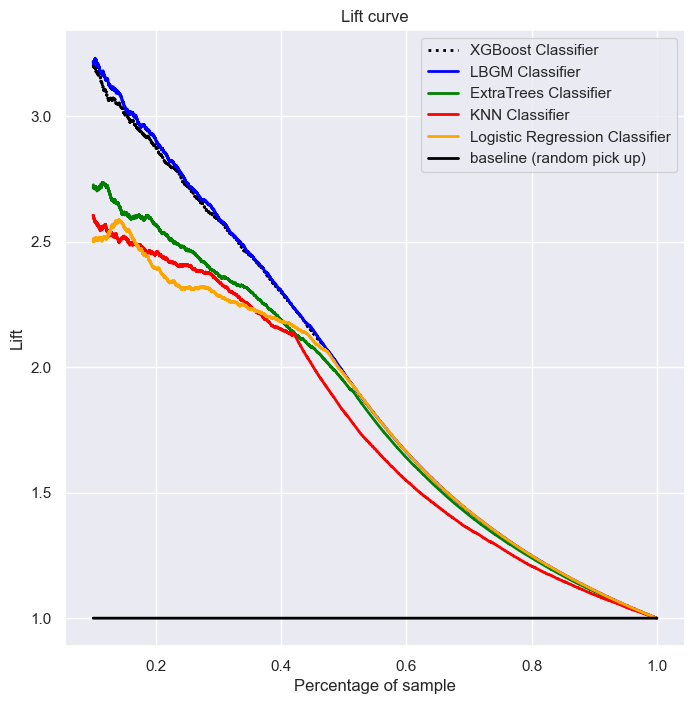

In [105]:
lift_xgb = table_xgb.query('cumulative_porc_base >= 0.1')
lift_lgbm = table_lgbm.query('cumulative_porc_base >= 0.1')
lift_et = table_et.query('cumulative_porc_base >= 0.1')
lift_knn = table_knn.query('cumulative_porc_base >= 0.1')
lift_lr = table_lr.query('cumulative_porc_base >= 0.1')

# plot the graphics
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.lineplot(ax = axes, x = lift_xgb['cumulative_porc_base'], y = lift_xgb['lift'], label="XGBoost Classifier", linewidth = 2, color = 'black')
sns.lineplot(ax = axes, x = lift_lgbm['cumulative_porc_base'], y = lift_lgbm['lift'], label="LBGM Classifier", linewidth = 2, color = 'blue')
sns.lineplot(ax = axes, x = lift_et['cumulative_porc_base'], y = lift_et['lift'], label="ExtraTrees Classifier", linewidth = 2, color = 'green')
sns.lineplot(ax = axes, x = lift_knn['cumulative_porc_base'], y = lift_knn['lift'], label="KNN Classifier", linewidth = 2, color = 'red')
sns.lineplot(ax = axes, x = lift_lr['cumulative_porc_base'], y = lift_lr['lift'], label="Logistic Regression Classifier", linewidth = 2, color = 'orange')
sns.lineplot(ax = axes, x = lift_xgb['cumulative_porc_base'], y = np.ones(len(lift_xgb)), label="baseline (random pick up)", linewidth = 2, color = 'black')



axes.lines[0].set_linestyle(":")

axes.legend()
axes.set_title("Lift curve")
axes.set_xlabel("Percentage of sample")
axes.set_ylabel("Lift")

axes.plot;

## 7.7 Cross validation

### 7.7.1 KNN

In [106]:
knn_cv_metrics = cross_validation(knn_model, "KNN Classifier", X_train, y_train, k, 5)

knn_cv_metrics

,Model name,precision_at_k,recall_at_k
0,KNN Classifier,0.299+/-0.0022,0.5422+/-0.0041


### 7.7.2 Logistic Regression

In [107]:
lr_cv_metrics = cross_validation(lr_model, "LogisticRegression Classifier", X_train, y_train, k, 5)

lr_cv_metrics

,Model name,precision_at_k,recall_at_k
0,LogisticRegression Classifier,0.2856+/-0.0017,0.5178+/-0.0031


### 7.7.3 LBGM

In [108]:
lgbm_cv_metrics = cross_validation(lgbm_model, "LGBM Classifier", X_train, y_train, k, 5)

lgbm_cv_metrics

,Model name,precision_at_k,recall_at_k
0,LGBM Classifier,0.343+/-0.0027,0.6218+/-0.0048


### 7.7.4 ExtraTrees

In [109]:
et_cv_metrics = cross_validation(et_model, "ExtraTrees Classifier", X_train, y_train, k, 5)

et_cv_metrics

,Model name,precision_at_k,recall_at_k
0,ExtraTrees Classifier,0.3097+/-0.0018,0.5615+/-0.0032


###  7.7.5 XGB Classifier

In [110]:
xgb_cv_metrics = cross_validation(xgb_model, "XGBoost Classifier", X_train, y_train, k, 5)

xgb_cv_metrics

,Model name,precision_at_k,recall_at_k
0,XGBoost Classifier,0.3408+/-0.0023,0.6179+/-0.0042


### 7.7.6 Results

In [111]:
results_cv = pd.concat([knn_cv_metrics, lr_cv_metrics, lgbm_cv_metrics, et_cv_metrics, xgb_cv_metrics])

results_cv.sort_values(by = 'recall_at_k', ascending = False)

,Model name,precision_at_k,recall_at_k
0,LGBM Classifier,0.343+/-0.0027,0.6218+/-0.0048
0,XGBoost Classifier,0.3408+/-0.0023,0.6179+/-0.0042
0,ExtraTrees Classifier,0.3097+/-0.0018,0.5615+/-0.0032
0,KNN Classifier,0.299+/-0.0022,0.5422+/-0.0041
0,LogisticRegression Classifier,0.2856+/-0.0017,0.5178+/-0.0031


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random search

In [112]:
param = {'learning_rate':[1e-3, 1e-1],
         'num_leaves':[2, 20, 50, 100, 120],
         'min_child_samples':[1, 5, 10, 25, 50, 75, 100],
         'subsample':[0.05, 0.10, 0.25, 0.50, 0.75, 1.0],
         'colsample_bytree':[0.1, 0.5, 0.7, 1.0],
        }

MAX_EVAL = 5

In [113]:
#final_result = pd.DataFrame()
#hyperparam_lst = []
#
#for i in range(MAX_EVAL):
#    #randomly selected hyperparameters
#    hp = {k:random.sample(v, 1)[0] for k, v in param.items()}
#    #print the selected ones
#    print(hp)
#    #store in list
#    hyperparam_lst.append(hp.copy())
#    #model
#    model_lgbm = LGBMClassifier(learning_rate=hp['learning_rate'],
#                               num_leaves=hp['num_leaves'],
#                               min_child_samples=hp['min_child_samples'],
#                               subsample=hp['subsample'],
#                               colsample_bytree=hp['colsample_bytree'],
#                               random_state=0, 
#                               subsample_freq=1,
#                               n_estimators=1000,
#                               verbose=-1,
#                               class_weight='balanced'
#                               )
#    result = cross_validation(model_lgbm, 'LBGM Classifier', X_train, y_train, k, 5)
#    iter_nr = pd.Series([i], name='Iter_nr')
#    result_w_nr = pd.concat([result, iter_nr], axis=1)
#    final_result = pd.concat([final_result, result_w_nr], ignore_index=True)
#
#final_result.sort_values(by=['precision_at_k'], ascending=False, inplace=True, ignore_index=True)
#final_result

{'learning_rate': 0.1, 'num_leaves': 2, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.1}
{'learning_rate': 0.1, 'num_leaves': 100, 'min_child_samples': 100, 'subsample': 0.25, 'colsample_bytree': 0.7}
{'learning_rate': 0.1, 'num_leaves': 2, 'min_child_samples': 5, 'subsample': 0.25, 'colsample_bytree': 0.7}
{'learning_rate': 0.1, 'num_leaves': 50, 'min_child_samples': 1, 'subsample': 0.5, 'colsample_bytree': 1.0}
{'learning_rate': 0.001, 'num_leaves': 100, 'min_child_samples': 5, 'subsample': 1.0, 'colsample_bytree': 0.5}


,Model name,precision_at_k,recall_at_k,Iter_nr
0,LBGM Classifier,0.3431+/-0.0029,0.6221+/-0.0052,4
1,LBGM Classifier,0.3414+/-0.0026,0.619+/-0.0047,2
2,LBGM Classifier,0.3399+/-0.0031,0.6163+/-0.0056,0
3,LBGM Classifier,0.3198+/-0.0016,0.5798+/-0.0028,1
4,LBGM Classifier,0.3128+/-0.0099,0.5672+/-0.0178,3


In [114]:
# select the hyperparameters that resulted in best accuracy
#best_param_nr = final_result.loc[0, 'Iter_nr']
#
#param_tuned = hyperparam_lst[best_param_nr]
#
#param_tuned

{'learning_rate': 0.001,
 'num_leaves': 100,
 'min_child_samples': 5,
 'subsample': 1.0,
 'colsample_bytree': 0.5}

In [119]:
param_tuned = {'learning_rate': 0.001,
 'num_leaves': 100,
 'min_child_samples': 5,
 'subsample': 1.0,
 'colsample_bytree': 0.5}

## 8.2 - Final model

In [123]:
# Model tuned
model_lgbm_tuned = LGBMClassifier(learning_rate=param_tuned['learning_rate'],
                               num_leaves=param_tuned['num_leaves'],
                               min_child_samples=param_tuned['min_child_samples'],
                               subsample=param_tuned['subsample'],
                               colsample_bytree=param_tuned['colsample_bytree'],
                               random_state=0, 
                               subsample_freq=1,
                               n_estimators=1000,
                               verbose=-1,
                               class_weight='balanced'
                               )

In [125]:
pickle.dump(model_lgbm_tuned, open('../models/model_healthinsurance_lgbm_1.pkl', 'wb'))

In [126]:
# Model training
model_lgbm_tuned.fit(X_train, y_train.values.ravel())

# Model prediction (proba)
yhat_proba_lgbm = model_lgbm_tuned.predict_proba(X_val);

# Model prediction
yhat_predict_lgbm = model_lgbm_tuned.predict(X_val);

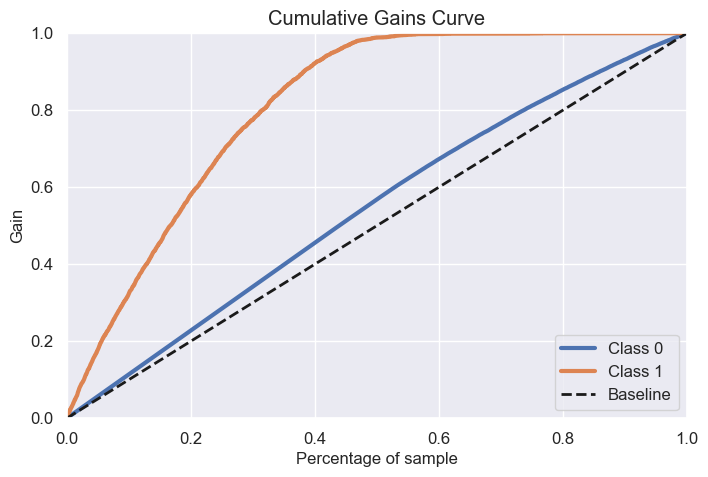

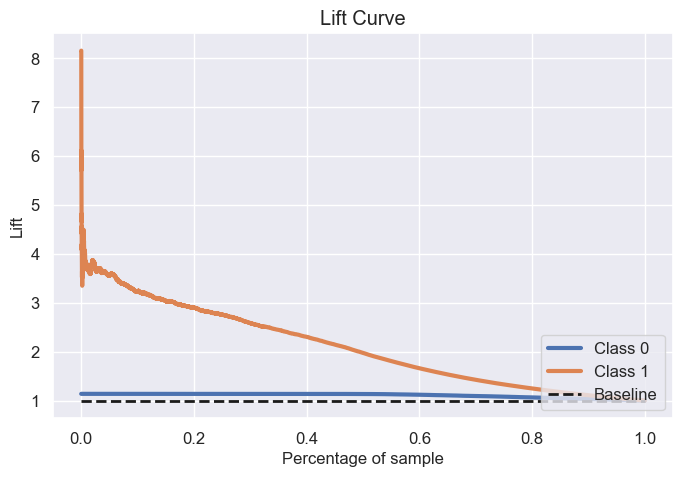

In [127]:
# Accuracy
accuracy_lgbm = accuracy_score(y_val, yhat_predict_lgbm)

# Precision
precision_lgbm = precision_score(y_val, yhat_predict_lgbm)

# Recall
recall_lgbm = recall_score(y_val, yhat_predict_lgbm)

# Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_lgbm, figsize = (8,5));

# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_proba_lgbm, figsize = (8,5));

# Precision@k and Recall@k
metrics_lgbm, table_lgbm = precision_recall_at_k(yhat_proba_lgbm, y_val, k)

# Join results
lgbm_results = pd.DataFrame({
    'Model Name':'LBGM Classifier',
    'Accuracy':accuracy_lgbm, 
    'Precision':precision_lgbm, 
    'Recall':recall_lgbm, 
    'Precision@K':metrics_lgbm[0], 
    'Recall@K':metrics_lgbm[1]
}, index=[0])

In [128]:
lgbm_results

,Model Name,Accuracy,Precision,Recall,Precision@K,Recall@K
0,LBGM Classifier,0.700909,0.281362,0.926679,0.282575,0.92213


# 9.0 Business Peformance

# 10.0 HealthInsurance Class